In [490]:
import numpy as np
import scipy
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt

### Data Generation

In [491]:
def piecewise_const_function(c, x, y):
    assert(x <= y)
    def function(point):
        if point >= x and point < y:
            return c
        else:
            return 0
    return np.vectorize(function)

In [507]:
def true_function_1():
    coef = np.random.rand(20, 4)
    combination = []
    for i in range(20):
        if coef[i][0] > coef[i][1]:
            coef[i][0], coef[i][1] = coef[i][1], coef[i][0]
        combination.append(piecewise_const_function(coef[i][2], coef[i][0], coef[i][1]))
    def function(x):
        s = 0
        for i in range(20):
            #print(coef[i][3] * combination[i](x))
            s += coef[i][3] * combination[i](x)
        return s
    true_theta = coef[:, 3]
    return np.vectorize(function), true_theta 

In [493]:
func1 = piecewise_const_function(1, 0, 0.5)

In [494]:
N_POINTS = 1000
beta = 1
X = 2

x = np.linspace(0, 1, num=N_POINTS)

In [495]:
def generate_basis(start, end, value=1):
    basis_functions = []
    for i in range(10):
        interval_size = (end - start) / 2**i
        for j in range(2**i - 1):
            func = piecewise_const_function(value, j * interval_size, (j + 1) * interval_size)
            basis_functions.append(func)
    return basis_functions

def generate_w(start_end, value = 1):
    w = []
    for i in range(10):
        interval_size = (end - start) / 2**i
        for j in range(2**i - 1):
            w.append(interval_size)
    return np.array(w)

In [496]:
def generate_noize(x):
    dimensions = x.shape[0]
    return np.random.multivariate_normal(0 * np.ones(dimensions), 0.01 * np.eye(dimensions))

In [497]:
def generate_psi(x):
    PSI_arr = []
    for basis_function in generate_basis(0, 1):
        PSI_arr.append(basis_function(x).astype(np.float64))

    PSI = np.vstack(PSI_arr)
    return PSI

In [498]:
def emperical_risk(theta_true, theta_pred, W = None):
    if W is None:
        W = np.eye(theta_true.shape[0])
    diff = W @ (theta_true - theta_pred)
    return np.mean(diff**2)

In [508]:
true_function, true_theta = true_function_1()

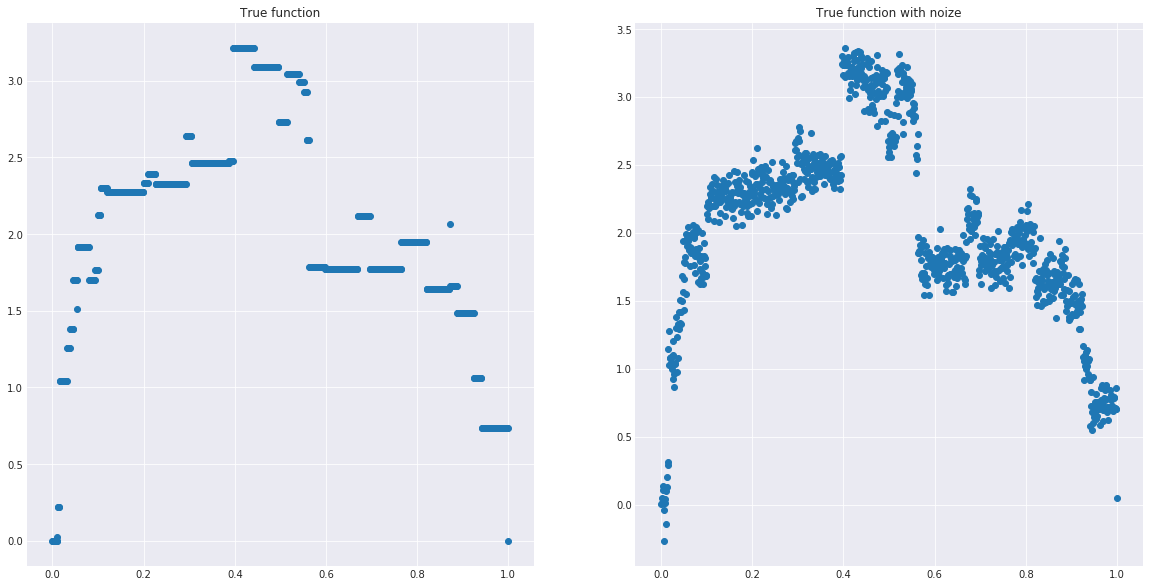

In [510]:
with sns.axes_style('darkgrid'):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    ax1.scatter(x, true_function(x))
    ax1.set_title('True function')
    ax2.scatter(x, true_function(x) + generate_noize(x))
    ax2.set_title('True function with noize')
    plt.show()

In [511]:
from sklearn.cross_validation import train_test_split

In [512]:
y = generate_noize(x) + true_function(x)
X_train, X_holdout, y_train, y_holdout = train_test_split(x, y)

In [531]:
PSI = generate_psi(X_train)

theta = (np.linalg.pinv(PSI @ PSI.T) @ PSI ) @ y_train

prediction = generate_psi(X_holdout).T @ theta

W = generate_w(0, 1)

true_theta_bigdim = np.zeros_like(theta)
true_theta_bigdim[:len(true_theta)] = true_theta

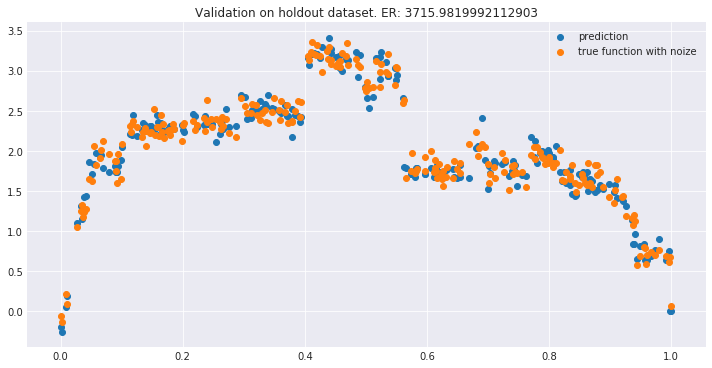

In [537]:
with sns.axes_style('darkgrid'):
    plt.figure(figsize=(10, 5))
    plt.scatter(X_holdout, prediction, label='prediction')
    plt.scatter(X_holdout, y_holdout, label='true function with noize')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.title('Validation on holdout dataset. ER: {}'.format(emperical_risk(true_theta_bigdim, theta, W=W)))
    plt.show()

### Weighting matrix


$$
\int_{0}^{1} c I(a, b) dx= c\int_{0}^{1} I[a, b)dx = c\int_{\max(0, a)}^{min(1, b)}dx = c(\min(1, b) - \max(0, a))
$$ 

Sice we consider our function on the $[0, 1]$ interval, we can just say that $W_i = b_i - a_i$